In [1]:
import torch 
from torch.nn import functional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
#datset
data=pd.read_csv("dataset/Iris.csv")
data = data[data["Species"].isin(['Iris-setosa', 'Iris-versicolor'])]
data['Species'] = data['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1})
X = data[['SepalLengthCm', 'SepalWidthCm']].values.tolist()
y = list(data['Species'])
print("len of X: ",len(X))
print("len of y: ",len(y))
print(X[:5])
print(y[:5])
X=torch.tensor(X,dtype=torch.float32)
y=torch.tensor(y,dtype=torch.float32)
torch.manual_seed(42)
shuffle_indices= torch.randperm(len(y),dtype=torch.long)
X=X[shuffle_indices]
y=y[shuffle_indices]
x_train,x_test=X[:70],X[70:]
y_train,y_test=y[:70],y[70:]
# Standarization
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)
X_train = (x_train - mu) / sigma
X_test = (x_test - mu) / sigma

len of X:  100
len of y:  100
[[5.1, 3.5], [4.9, 3.0], [4.7, 3.2], [4.6, 3.1], [5.0, 3.6]]
[0, 0, 0, 0, 0]


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# manual implementation of logistic regression
class logistic_regression_manual(): 
    def __init__(self, num_features=2):
        self.num_features = num_features
        self.weights = torch.zeros(num_features,1 ,dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
    def activation(self,x):
        
        # sigmoid=torch.tensor([1/(1+math.exp(-i)) for i in x])   # here is sigmoid function manually calculate. 
        sigmoid= 1/(1+torch.exp(-x))
        return sigmoid
    def forward(self, x):
        x_w = torch.add(torch.matmul(x,self.weights), self.bias).view(-1)
        probs=self.activation(x_w)
        return probs
        
    def backward(self, x, y, probs):  
        grad_loss_y = probs.view(-1)-y
        grad_loss_weights =  torch.matmul(x.t(),grad_loss_y.view(-1)).t() # torch.matmul is used instaed of torch.mm
        grad_loss_bias = torch.sum(grad_loss_y)
        return grad_loss_weights, grad_loss_bias
    
    def perdicted_labels(self, x):
        probs=self.forward(x)
        labels=torch.where(probs>=0.5, 1, 0)
        return labels

    def evaluation(self, x,y):
        y_pred=self.perdicted_labels(x).float()
        acc=sum(p == t for p, t in zip(y_pred, y))/len(y)
        return acc


    def logits(self,probs,y): 
        y_1=torch.matmul(-y.view(-1), torch.log(probs.view(-1)))
        y_0=torch.matmul((1-y).view(-1), torch.log((1-probs).view(-1)))
        return y_1-y_0
    
    def train(self,X,y, epochs=10, lr=0.01):
        error_per_epoch=[]
        for e in range(epochs):
            y_pred=self.forward(X)
            w_grad, b_grad=self.backward(X,y,y_pred)
            self.weights-=w_grad.unsqueeze(1)*lr
            self.bias-=b_grad*lr
            
            loss=(self.logits(self.forward(X),y) / X.size(0)).tolist()
            error_per_epoch.append(loss)
            acc=self.evaluation(X,y)
            print(f"Epoch : {e}  ; Current loss: {loss}; Accuracy: {acc}")
        return error_per_epoch

In [5]:
x_train=torch.tensor(x_train,device=device, dtype=torch.float32)
y_train=torch.tensor(y_train,device=device, dtype=torch.float32)
model1=logistic_regression_manual()
loss=model1.train(x_train,y_train, epochs=100)
print("weights: ",model1.weights.tolist())
print("bias: ",model1.bias.tolist())


C:\Users\HP\AppData\Local\Temp\ipykernel_14252\2983073880.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train=torch.tensor(x_train,device=device, dtype=torch.float32)
C:\Users\HP\AppData\Local\Temp\ipykernel_14252\2983073880.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train=torch.tensor(y_train,device=device, dtype=torch.float32)


Epoch : 0  ; Current loss: 0.7921351790428162; Accuracy: 0.5285714268684387
Epoch : 1  ; Current loss: 3.059091329574585; Accuracy: 0.4714285731315613
Epoch : 2  ; Current loss: 4.343508720397949; Accuracy: 0.5285714268684387
Epoch : 3  ; Current loss: 1.5869539976119995; Accuracy: 0.4714285731315613
Epoch : 4  ; Current loss: 4.9040422439575195; Accuracy: 0.5285714268684387
Epoch : 5  ; Current loss: 0.8354772925376892; Accuracy: 0.4714285731315613
Epoch : 6  ; Current loss: 3.8345580101013184; Accuracy: 0.5285714268684387
Epoch : 7  ; Current loss: 1.7572965621948242; Accuracy: 0.4714285731315613
Epoch : 8  ; Current loss: 4.602991104125977; Accuracy: 0.5285714268684387
Epoch : 9  ; Current loss: 0.7759355306625366; Accuracy: 0.48571428656578064
Epoch : 10  ; Current loss: 3.5819926261901855; Accuracy: 0.5285714268684387
Epoch : 11  ; Current loss: 1.650860071182251; Accuracy: 0.4714285731315613
Epoch : 12  ; Current loss: 4.289453506469727; Accuracy: 0.5285714268684387
Epoch : 13  ;

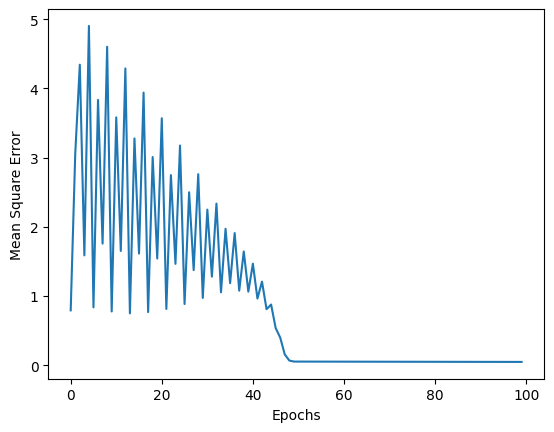

In [6]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()

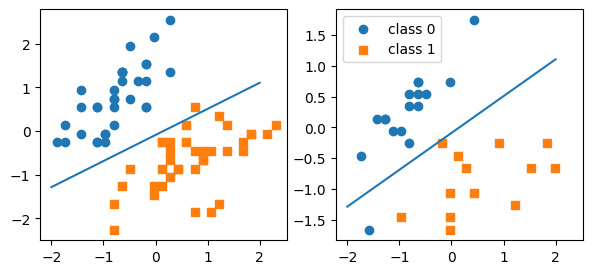

In [9]:
w, b = model1.weights.view(-1), model1.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] ).item()

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] ).item()


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])
x_train_plt=X_train.to('cpu')
x_test_plt=X_test.to('cpu')
y_test_plt=y_test.to('cpu')
y_train_plt=y_train.to('cpu')
ax[0].scatter(x_train_plt[y_train_plt==0, 0], x_train_plt[y_train_plt==0, 1], label='class 0', marker='o')
ax[0].scatter(x_train_plt[y_train_plt==1, 0], x_train_plt[y_train_plt==1, 1], label='class 1', marker='s')

ax[1].scatter(x_test_plt[y_test_plt==0, 0], x_test_plt[y_test_plt==0, 1], label='class 0', marker='o')
ax[1].scatter(x_test_plt[y_test_plt==1, 0], x_test_plt[y_test_plt==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [10]:
X_test= torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)
test_results=model1.forward(X_test)
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Correct : ",correct.tolist())
print("Wrong: ",len(y_test)-correct.item())
print("Accuracy: ", correct.item()/len(y_test) )


C:\Users\HP\AppData\Local\Temp\ipykernel_14252\424987519.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test= torch.tensor(X_test, dtype=torch.float32, device=device)


Correct :  [29]
Wrong:  1
Accuracy:  0.9666666666666667


C:\Users\HP\AppData\Local\Temp\ipykernel_14252\424987519.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)


In [11]:
class Logistic_regression(torch.nn.Module):
    def __init__(self, num_features=2):
        super(Logistic_regression, self).__init__()
        self.layer=torch.nn.Linear(num_features,1)
        self.layer.weight.detach().zero_()
        self.layer.bias.detach().zero_()
    
    def forward(self, x):
        logits=self.layer(x)
        probs=functional.sigmoid(logits)
        return probs

def accuracy(y, pred_prob):
    pred_prob=pred_prob.view(-1).float()
    y_pred=torch.where(pred_prob >= 0.5, 1, 0)
    acc=sum(p == t for p, t in zip(y_pred, y))/len(y)
    return acc

def train(X,y,model, epochs=10, lr=0.01):
    loss_per_epoch=[]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 

    for e in range(epochs):
        y_pred=model(X)
        loss=functional.binary_cross_entropy(y_pred, y, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred=model(X)
        acc=accuracy(y,y_pred).item()
        loss=functional.binary_cross_entropy(y_pred, y)
        print(f"Epoch : {e}  ; Current loss: {loss}; Accuracy: {acc}")
        ls=loss.item()
        loss_per_epoch.append(ls)
    return loss_per_epoch



In [12]:
model2=Logistic_regression().to(device)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
loss=train(X_train,y_train,model2, epochs=100)

C:\Users\HP\AppData\Local\Temp\ipykernel_14252\3888722327.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
C:\Users\HP\AppData\Local\Temp\ipykernel_14252\3888722327.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


Epoch : 0  ; Current loss: 0.5318381786346436; Accuracy: 1.0
Epoch : 1  ; Current loss: 0.42960721254348755; Accuracy: 1.0
Epoch : 2  ; Current loss: 0.36141592264175415; Accuracy: 1.0
Epoch : 3  ; Current loss: 0.3132934868335724; Accuracy: 1.0
Epoch : 4  ; Current loss: 0.27764955163002014; Accuracy: 1.0
Epoch : 5  ; Current loss: 0.2501968741416931; Accuracy: 1.0
Epoch : 6  ; Current loss: 0.22838212549686432; Accuracy: 1.0
Epoch : 7  ; Current loss: 0.21060523390769958; Accuracy: 1.0
Epoch : 8  ; Current loss: 0.19581761956214905; Accuracy: 1.0
Epoch : 9  ; Current loss: 0.18330511450767517; Accuracy: 1.0
Epoch : 10  ; Current loss: 0.17256514728069305; Accuracy: 1.0
Epoch : 11  ; Current loss: 0.16323386132717133; Accuracy: 1.0
Epoch : 12  ; Current loss: 0.15504147112369537; Accuracy: 1.0
Epoch : 13  ; Current loss: 0.1477835774421692; Accuracy: 1.0
Epoch : 14  ; Current loss: 0.14130251109600067; Accuracy: 1.0
Epoch : 15  ; Current loss: 0.13547460734844208; Accuracy: 1.0
Epoch 

In [13]:
print("weight: ",model2.layer.weight)
print("bias: ",model2.layer.bias)

weight:  Parameter containing:
tensor([[ 3.2207, -3.0045]], device='cuda:0', requires_grad=True)
bias:  Parameter containing:
tensor([0.5089], device='cuda:0', requires_grad=True)


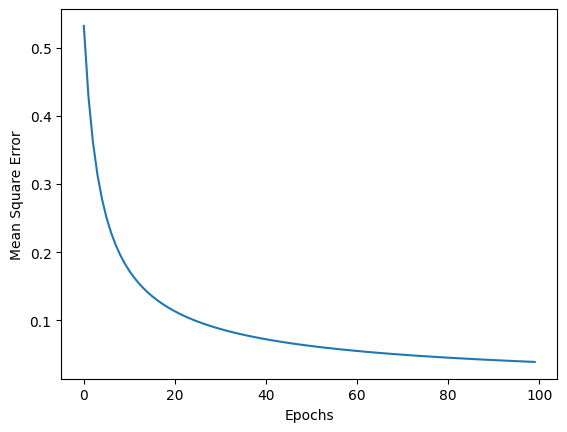

In [14]:
plt.plot(range(len(loss)), loss)
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')
plt.show()

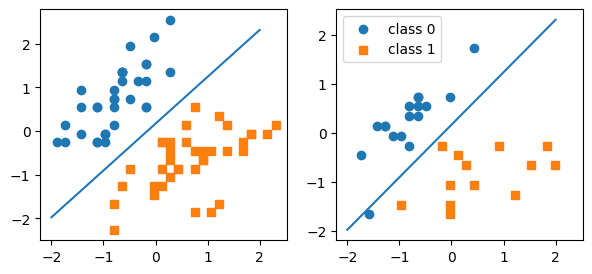

In [17]:
w, b = model2.layer.weight.detach().view(-1), model2.layer.bias.detach()

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] ).item()

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] ).item()


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])
ax[0].scatter(x_train_plt[y_train_plt==0, 0], x_train_plt[y_train_plt==0, 1], label='class 0', marker='o')
ax[0].scatter(x_train_plt[y_train_plt==1, 0], x_train_plt[y_train_plt==1, 1], label='class 1', marker='s')

ax[1].scatter(x_test_plt[y_test_plt==0, 0], x_test_plt[y_test_plt==0, 1], label='class 0', marker='o')
ax[1].scatter(x_test_plt[y_test_plt==1, 0], x_test_plt[y_test_plt==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

In [27]:
test_results=model2(X_test)
test_class=[1 if i>=0.5 else 0 for i in test_results]
correct= sum(p == t for p, t in zip(test_class, y_test))
print("Correct : ",correct.tolist())
print("Wrong: ",len(y_test)-correct.item())
print("Accuracy: ", correct.item()/len(y_test) )


Correct :  [29]
Wrong:  1
Accuracy:  0.9666666666666667
